In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
import glob
import warnings
sys.path.append('../')
from collections import OrderedDict

import ipywidgets as widgets

from rankutils.mappings import ranking_type_map, exp_aliases
from rankutils.cfgloader import cfgloader
from rankutils.evaluation import parsecolor
from rankutils.drawing import colors_from_cmap, irp_results_barh_draw, irp_results_pos_draw, rpp_results_draw

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, confusion_matrix, average_precision_score, precision_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

import mpld3

In [5]:
def draw_eval_curve(x, y, e, xlabel, ylabel, colors, ax=None, **drawargs):
    
    val = colors[1].value
    c = colors[0][val]
    
    if not ax:
        ax = plt.gca()

    hand = ax.plot(x, y, fillstyle='full', color=c, **drawargs)
    
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_yticks([y for y in np.arange(0.0, 1.1, 0.1)])
    ax.set_yticklabels(["{0:0.0%}".format(y) for y in np.arange(0.0, 1.1, 0.1)], fontdict=dict(fontsize=12))
    if ylabel:
        ax.set_ylabel(ylabel, fontdict=dict(fontsize=12))
        
    ax.set_xlim(left=1.0, right=k)
    ax.set_xticks([x for x in np.arange(1, x.size+1, 1)])
    ax.set_xticklabels(["{0:d}".format(x) for x in np.arange(1, k + 1, 1)], fontdict=dict(fontsize=8))
    if xlabel:
        ax.set_xlabel(xlabel, fontdict=dict(fontsize=12))
        
    return hand

In [6]:
def draw_eval_hbars_double(x, yA, yB, eA, eB, labels, xlabel, ylabel, colors, ax=None):
    
    if not ax:
        ax = plt.gca()
        
    for i, m in enumerate(yA.keys()):
        
        val = colors[m][1].value
        c1 = colors[m][0][val]

        rect, = ax.barh(x[i]-0.01, width=yA[m], height=-0.3, left=0, color=c1, 
                        alpha=0.9, align='edge', xerr=eA[m], ecolor='black')
        
        posx = rect.get_x()
        posy = rect.get_y()
        hgt = rect.get_height()
        wdt = rect.get_width()
        
        #print("First", posy, ":", yA[i])
        
        if wdt >= 0:
            alg = 'left'
        else:
            alg = 'right'
        
        ax.text(posx + wdt + 0.01, posy, "{0:0.3f}".format(yA[m]), fontsize=11, bbox={'alpha': 0.0},
                color='black', fontweight='bold', horizontalalignment=alg)
        
        
        val = colors[m][2].value
        c2 = colors[m][0][val]
        
        rect, = ax.barh(x[i]+0.01, width=yB[m], height=0.3, left=0, color=c2, 
                        alpha=0.9, align='edge', xerr=eB[m], ecolor='black')
        
        posx = rect.get_x()
        posy = rect.get_y()
        hgt = rect.get_height()
        wdt = rect.get_width()
        
        #print("Second", posy, ":", yB[i], "\n")
        
        if wdt >= 0:
            alg = 'left'
        else:
            alg = 'right'
        
        ax.text(posx + wdt + 0.01, posy + hgt, "{0:0.3f}".format(yB[m]), fontsize=11, bbox={'alpha': 0.0},
                color='black', fontweight='bold', horizontalalignment=alg)
    
    
    ax.set_xlim(left=-1.25, right=1.25)
    ax.set_xticks(np.arange(-1.0, 1.1, 0.2))
    ax.set_xticklabels(["{0:0.1f}".format(x) for x in np.arange(-1.0, 1.1, 0.2)])
    if xlabel:
        ax.set_xlabel(xlabel, fontdict=dict(fontsize=12))
        
    ax.set_ylim(bottom=0.5, top=x[-1]+0.5)
    ax.set_yticks(x)
    ytl = [labels[k] for k in labels.keys()]
    #print(ytl)
    ax.set_yticklabels(ytl)
    if ylabel:
        ax.set_ylabel(ylabel, fontdict=dict(fontsize=12))
        
    return

In [7]:
def evaluate(gt, p, k):
    
    if p.ndim == 2:
        r = p.shape[0]
        p = p.reshape(1, r, -1)
        
    nrounds = p.shape[0]
    n = p.shape[1]
    
    bacc_eval = np.zeros((nrounds, k), dtype=np.float64)
    tpr_eval = np.zeros((nrounds, k), dtype=np.float64)
    tnr_eval = np.zeros((nrounds, k), dtype=np.float64)
    mcc_eval = np.zeros((nrounds, k), dtype=np.float64)
    
    mcc_all = np.zeros(nrounds, dtype=np.float64)
    mcc_exc1_all = np.zeros(nrounds, dtype=np.float64)
    
    f1_sample = np.zeros((n, nrounds), dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(k):
            
            y_true = gt[:, i]
            y_pred = pr[:, i]
            
            bacc_eval[r, i] = balanced_accuracy_score(y_true, y_pred)
            mcc_eval[r, i] = matthews_corrcoef(y_true, y_pred)
            
            cfmat = confusion_matrix(y_true, y_pred)
            
            if cfmat.size > 1:
                tn, fp, fn, tp = cfmat.ravel()
                tpr_eval[r, i] = tp/(tp + fn)
                tnr_eval[r, i] = tn/(tn + fp)
            else:
                if y_true[0] == 1:
                    tpr_eval[r, i] = 1.0
                    tnr_eval[r, i] = 1.0
        
        for j in range(n):
            
            y_true = gt[j, 1:k]
            y_pred = pr[j, 1:k]
            
            f1_sample[j, r] = f1_score(y_true, y_pred)
            
        y_true = gt[:, 0:k].reshape(-1)
        y_pred = pr[:, 0:k].reshape(-1)
        
        mcc_all[r] = matthews_corrcoef(y_true, y_pred)
        
        y_true = gt[:, 1:k].reshape(-1)
        y_pred = pr[:, 1:k].reshape(-1)
        
        mcc_exc1_all[r] = matthews_corrcoef(y_true, y_pred)
        
        #print(f1_all)
            
    return bacc_eval, tpr_eval, tnr_eval, f1_sample, mcc_eval, mcc_all, mcc_exc1_all

In [8]:
def evaluate_itv(gt, p, s, k):
    
    #print(gt.shape)
    #print(p.shape)
    
    if p.ndim == 2:
        r = p.shape[0]
        p = p.reshape(1, r, -1)
        
    nrounds = p.shape[0]
    
    bacc_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    tpr_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    tnr_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    mcc_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    ppv_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    
    mcc_all = np.zeros(nrounds, dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(s, k):
            
            y_true = gt[:, i]
            y_pred = pr[:, i]
            
            bacc_eval[r, i-s] = balanced_accuracy_score(y_true, y_pred)
            mcc_eval[r, i-s] = matthews_corrcoef(y_true, y_pred)
            
            v = precision_score(y_true, y_pred)
            if np.isnan(v):
                ppv_eval[r, i-s] = 0
            else:
                ppv_eval[r, i-s] = v
            
            cfmat = confusion_matrix(y_true, y_pred)
            
            if cfmat.size > 1:
                tn, fp, fn, tp = cfmat.ravel()
                tpr_eval[r, i-s] = tp/(tp + fn)
                tnr_eval[r, i-s] = tn/(tn + fp)
            else:
                if y_true[0] == 1:
                    tpr_eval[r, i-s] = 1.0
                    tnr_eval[r, i-s] = 1.0
            
        y_true = gt[:, s:k].reshape(-1)
        y_pred = pr[:, s:k].reshape(-1)
        
        mcc_all[r] = matthews_corrcoef(y_true, y_pred)
            
    return bacc_eval, tpr_eval, tnr_eval, mcc_eval, ppv_eval, mcc_all

In [9]:
def get_optimal(gt, s, k):
    
    gt_ = gt[:, s:k]
    
    n = gt_.shape[0]
    
    optimal = np.zeros(gt.shape, dtype=np.uint8)
    optimal[:, 0:s] = 1
    
    for i in range(n):
        
        y_true = gt_[i]
        
        opt = np.zeros(y_true.shape, dtype=np.uint8)
        best = np.sum(y_true == opt)
        x = 0
        while not np.all(opt):
            opt[x] = 1
            x += 1
            v = np.sum(y_true == opt)
            if v >= best:
                optimal[i, s:k] = opt
                best = v
                
    return optimal

In [10]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
evalcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/evalcfg/thesis/0000.test_eval.cfg")
outdir = "/home/alberto/phD/projects/performance_prediction/ret-mr-learning/results/thesis/subset_scheme-s/"
dname = os.path.basename(outdir[:-1])
barfigsize=(20, 8)
linefigsize=(15, 15)
titleargs=dict(fontsize=14, horizontalalignment='center')
k = 10
s = 0

In [11]:
results = OrderedDict()
optimal = dict()

#keys = ['oxford_001']
#keys = ['oxford_001', 'oxford_002', 'oxford_003', 'oxford_004', 'oxford_005']
#keys = ['unicamp_001', 'unicamp_002', 'unicamp_003', 'unicamp_004', 'unicamp_005']
#keys = ['corel_001', 'corel_002']
#keys = ['places365_001', 'places365_002', 'places365_003']
#keys = ['vggfaces_001', 'vggfaces_002']
#keys = ['imagenet_001', 'imagenet_002', 'imagenet_003']


keys = ['unicamp_001', 'unicamp_002', 'unicamp_004']
keys += ['places365_002', 'places365_002']
keys += ['imagenet_001', 'imagenet_003']
keys += ['vggfaces_001', 'vggfaces_002']

#keys = ['unicamp_001', 'unicamp_002', 'unicamp_004',
#          'places365_001', 'places365_002',
#          'imagenet_001', 'imagenet_003', 
#          'vggfaces_001', 'vggfaces_002']




n = len(keys)

methods = [m for m in evalcfg if m != 'DEFAULT']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for key in tqdm(keys, desc='Key ', total=len(keys)):
        
        results[key] = OrderedDict()
        
        for m in tqdm(methods, desc='  .method', total=len(methods)):
            
            rktpdir = pathcfg.get(key, 'rktpdir')
            
            try:
                gtpath = glob.glob("{0:s}/*{1:s}*".format(pathcfg.get(key, 'label'), rktpdir))[0]
                predpath = glob.glob("{0:s}/{1:s}/*irp.npy".format(pathcfg.get(key, 'output'), m))[0]
                
                gt = np.load(gtpath)
                p = np.load(predpath)
                
                #opt = get_optimal(gt, s, k)
                
            except IndexError:
                print(key, m)
                raise

            results[key][m] = evaluate(gt, p, k)
            
            #if key not in optimal:
                #optimal[key] = evaluate_itv(gt, opt, s, k)

In [12]:
colors = OrderedDict()
labels = OrderedDict()
drawargs = OrderedDict()

for m in methods:
    colors[m] = [sns.light_palette(evalcfg.get(m, 'color'), reverse=True, n_colors=10), 0, 4]
    labels[m] = evalcfg.get(m, 'label')
    drawargs[m] = dict()

    for prop in evalcfg[m]:
        if prop not in evalcfg.defaults() and prop != 'color' and prop != 'label':
            drawargs[m][prop] = evalcfg.get(m, prop)

seq-label.0009.irp.fusion_score_1-2-3.k10.seq10.1slack.crf


IntSlider(value=0, max=7)

IntSlider(value=4, max=7)

seq-label.0006.irp.cid-jaccard-20-100.k10.seq10.1slack.crf


IntSlider(value=0, max=7)

IntSlider(value=4, max=7)

seq-label.0000.irp.raw-scores.k10.seq10.1slack.crf


IntSlider(value=0, max=7)

IntSlider(value=4, max=7)

pos-learn.0009.irp.fusion_score_1-2-3.k30.svc


IntSlider(value=0, max=7)

IntSlider(value=4, max=7)

pos-learn.0006.irp.cid-jaccard-20-100.k30.svc


IntSlider(value=0, max=7)

IntSlider(value=4, max=7)

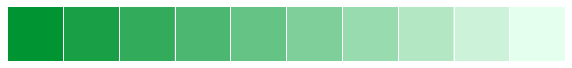

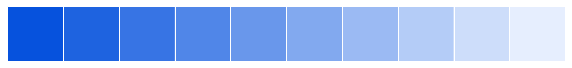

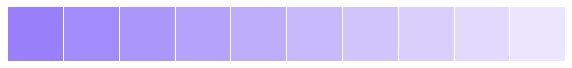

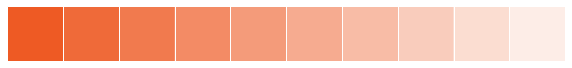

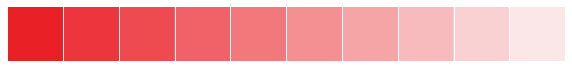

In [13]:
for m in methods:
    print(m)
    sns.palplot(colors[m][0])
    st = widgets.IntSlider(max=7)
    display(st)
    ed = widgets.IntSlider(value=4, max=7)
    display(ed)
    
    if ed.value < st.value:
        ed = st
        
    colors[m][1] = st
    colors[m][2] = ed

In [14]:
for m in methods:
    print(colors[m][1], colors[m][2])

IntSlider(value=0, max=7) IntSlider(value=4, max=7)
IntSlider(value=0, max=7) IntSlider(value=4, max=7)
IntSlider(value=0, max=7) IntSlider(value=4, max=7)
IntSlider(value=0, max=7) IntSlider(value=4, max=7)
IntSlider(value=0, max=7) IntSlider(value=4, max=7)


# Positional nACC

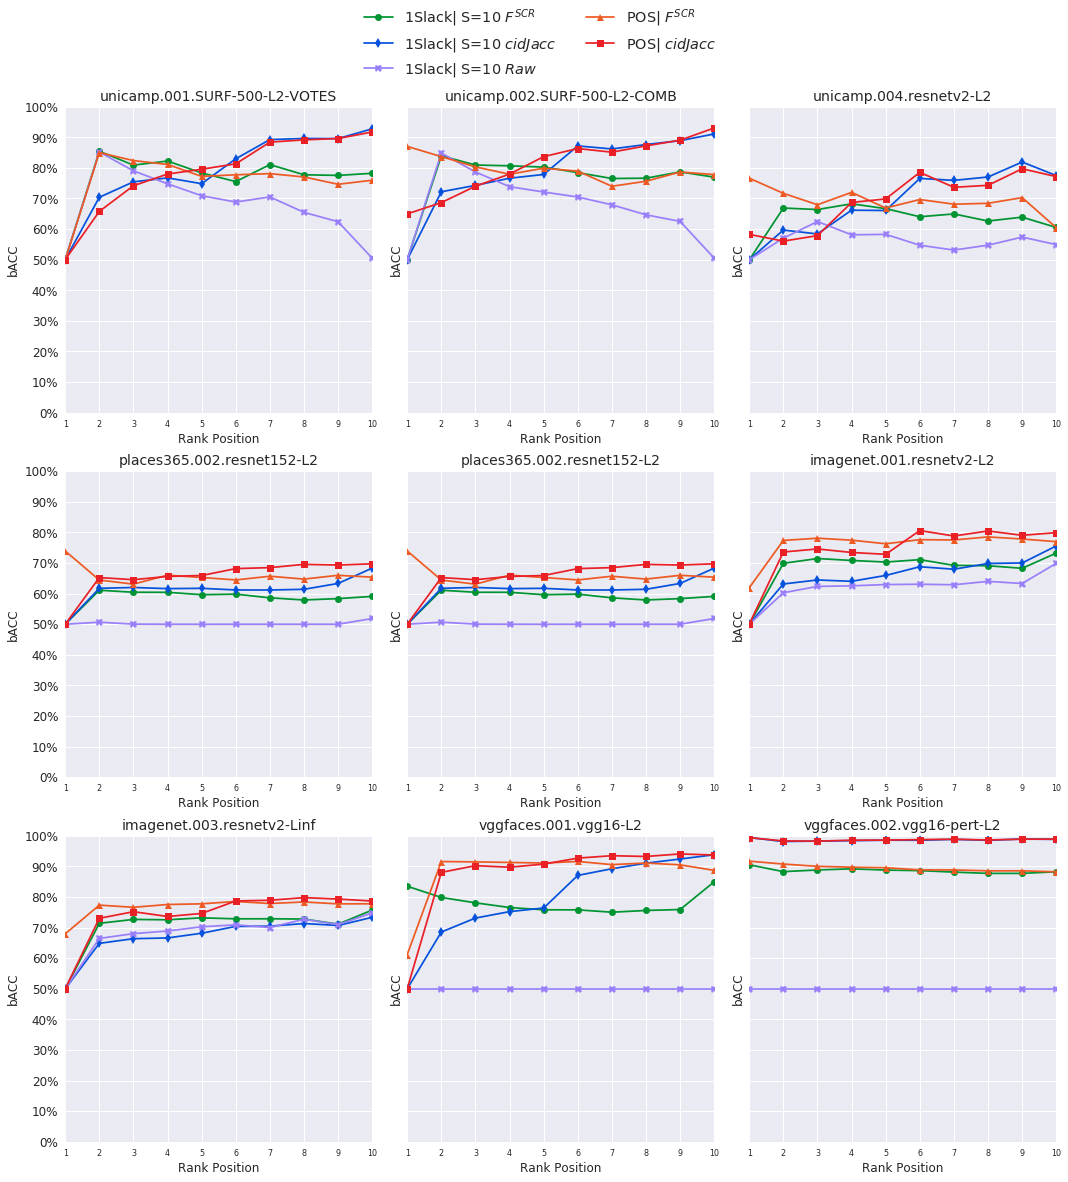

In [15]:
if n <= 3:
    rows = 1
    cols = n
elif n > 3 and n < 6:
    rows = 2
    cols = 3
else:
    rows = 3
    cols = 3
    
if rows == 1:
    tadj = 0.77
elif rows == 2:
    tadj = 0.87
elif rows == 3:
    tadj = 0.96
    
fig, axes = plt.subplots(rows, cols, sharey=True)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((5*cols, 5.5*rows))

leg_labels = []
leg_handles = []

for i, key in enumerate(keys):
    axes[i].set_title("{0:s}".format(exp_aliases[key]), fontdict=titleargs)
    
    for m in methods:
                    
        if labels[m] not in leg_labels:
            leg_labels.append(labels[m])
        
        x = np.arange(1+s, k+1)
        y = np.mean(results[key][m][0], axis=0)
        e = np.std(results[key][m][0], axis=0)
        
        h = draw_eval_curve(x, y, e, 'Rank Position', 'bACC', colors[m], axes[i], **drawargs[m])
        if i == 0:
            leg_handles.append(h[0])
            
    #axes[i].set_xticks([1] + [x for x in np.arange(5, x.size+1, 5)])
    #axes[i].set_xticklabels(["1"] + ["{0:d}".format(x) for x in np.arange(5, k + 1, 5)], fontdict=dict(fontsize=8))
                        
for j in range(i+1, len(axes)):
    axes[j].axis('off')
            

dset = key.split('_')[0]
dset = 'all'

if len(methods) <= 3:
    tadj -= 0.06
    leg_c = 1
else:
    tadj -= 0.05
    leg_c = 2

fig.legend(leg_handles, leg_labels, fancybox=True, shadow=True, loc='upper center', bbox_to_anchor=[0.5, 1.], ncol=leg_c,
           fontsize='large')
fig.tight_layout()
plt.subplots_adjust(top=tadj)
#plt.savefig('{0:s}/{1:s}_{2:s}_top{3:d}_bACC.pdf'.format(outdir, dset, dname, k), dpi=300)

## F1-Score

# MCC

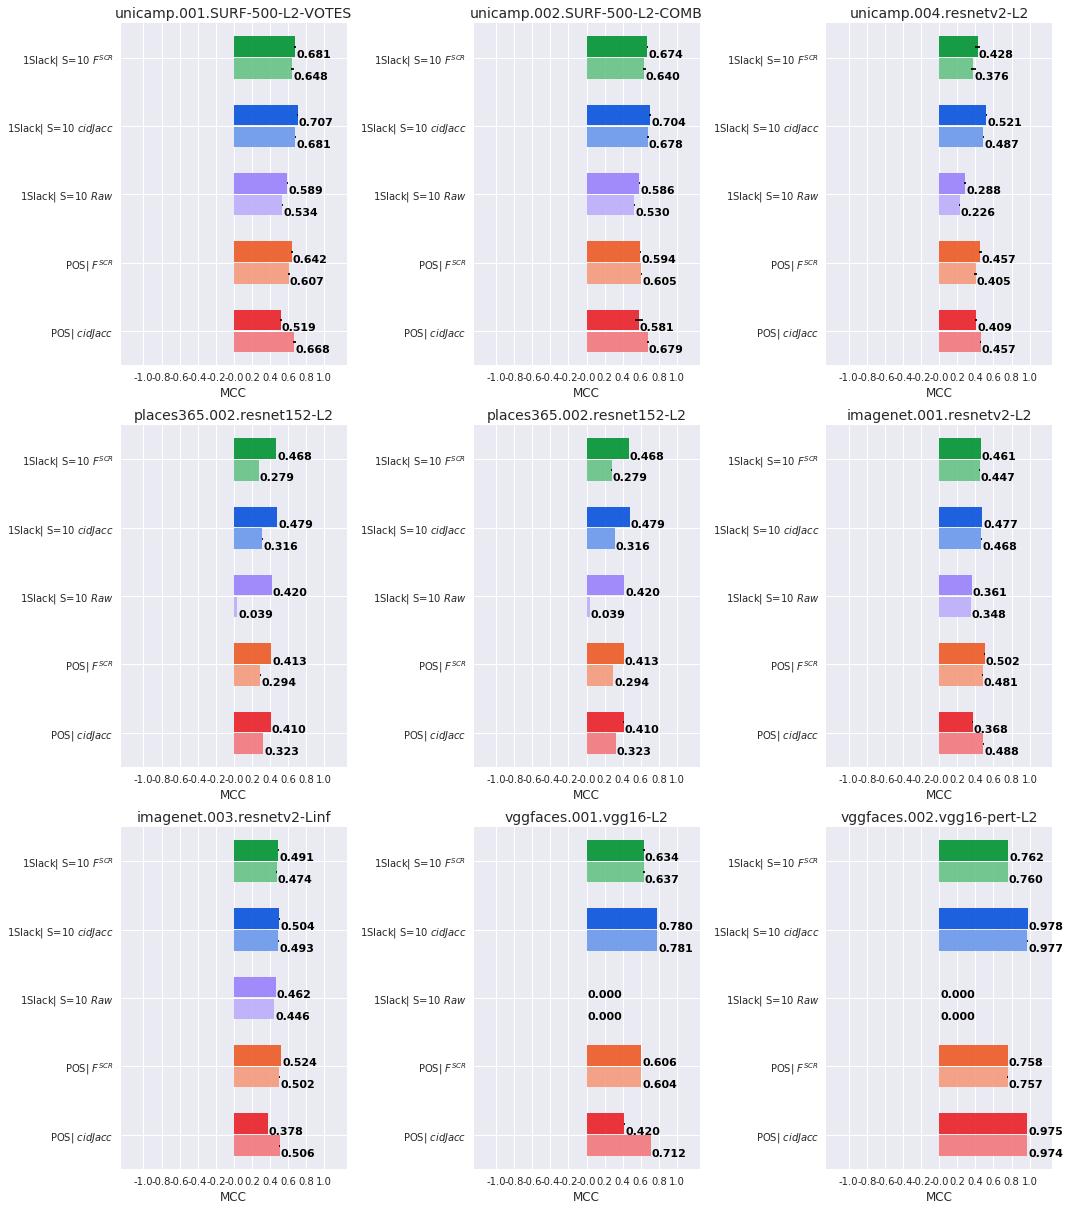

In [16]:
if n <= 3:
    rows = 1
    cols = n
elif n > 3 and n < 6:
    rows = 2
    cols = 3
else:
    rows = 3
    cols = 3
    
fig, axes = plt.subplots(rows, cols)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((5*cols, 6*rows))
    
for i, key in enumerate(keys):
    axes[i].set_title("{0:s}".format(exp_aliases[key]), fontdict=titleargs)
    
    yA = OrderedDict()
    eA = OrderedDict()
    yB = OrderedDict()
    eB = OrderedDict()
    
    #print("%%%%%%", results[key].keys())
    #for p in range(6):
    for m in methods:
        
        yA[m] = np.mean(results[key][m][-2], axis=0)
        eA[m] = np.std(results[key][m][-2], axis=0)
        yB[m] = np.mean(results[key][m][-1], axis=0)
        eB[m] = np.std(results[key][m][-1], axis=0)
        
    x = [v for v in range(1, len(yA)+1)]
    
    draw_eval_hbars_double(x, yA, yB, eA, eB, labels, 'MCC', None, colors, ax=axes[i])
    axes[i].invert_yaxis()
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')
            
fig.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('{0:s}/{1:s}_{2:s}_top{3:d}_MCC.pdf'.format(outdir, dset, dname, k), dpi=300)

## F1 Boxplot

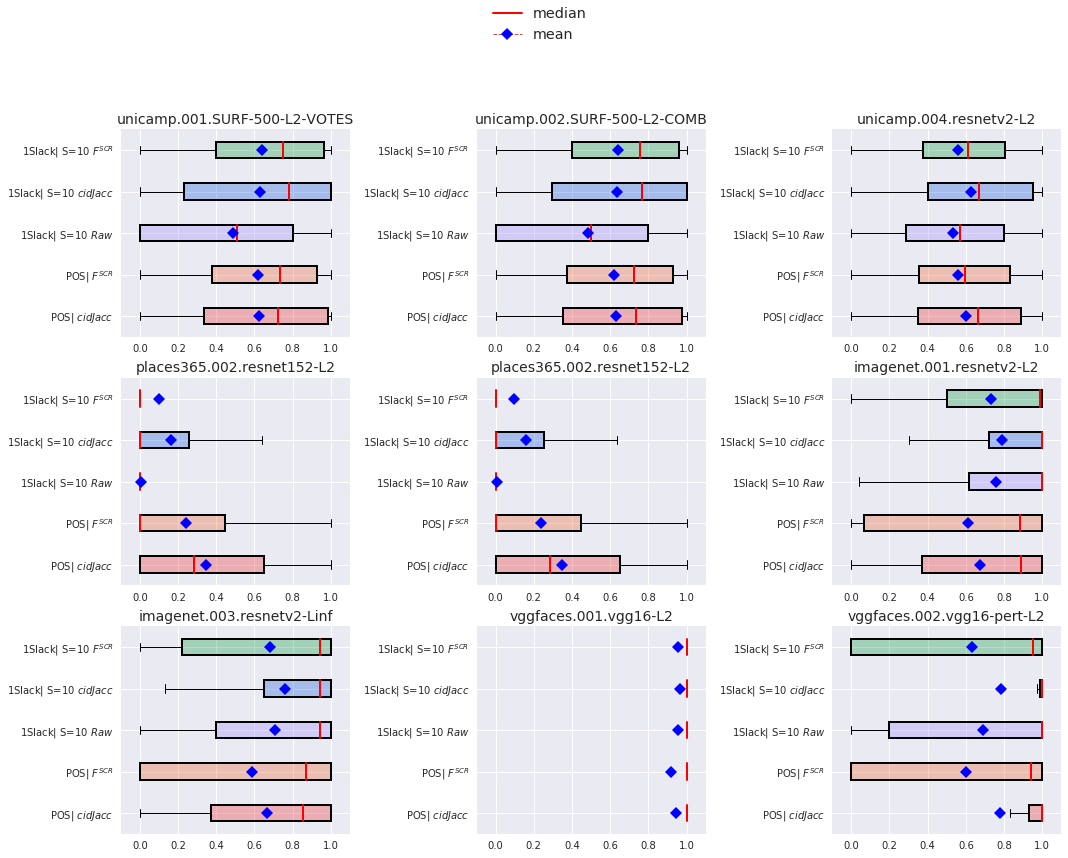

In [17]:
if n <= 3:
    rows = 1
    cols = n
elif n > 3 and n < 6:
    rows = 2
    cols = 3
else:
    rows = 3
    cols = 3
    
if rows == 1:
    tadj = 0.75
else:
    tadj = 0.85
    
fig, axes = plt.subplots(rows, cols)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((5*cols, 4*rows))


boxprops = dict(linewidth=2)
medianprops = dict(linewidth=2, color='red')
meanpointprops = dict(marker='D', markerfacecolor='blue', markersize=8)
for i, key in enumerate(keys):
    axes[i].set_title("{0:s}".format(exp_aliases[key]), fontdict=titleargs)
    
    yA = []
    
    for m in results[key]:
        #print(m)
        yA.append(results[key][m][3].mean(axis=1))
        
    #print([labels[k] for k in labels.keys()])
    bplot = axes[i].boxplot(yA, labels=[labels[k] for k in labels.keys()], vert=False, widths=0.4,
                    boxprops=boxprops, medianprops=medianprops, meanprops=meanpointprops, showmeans=True,
                    patch_artist=True)
    axes[i].set_xlim(left=-0.1, right=1.1)
    
    leg_handles = [bplot['medians'][0], bplot['means'][0]]
    leg_labels = ['median', 'mean']
    
    axes[i].invert_yaxis()
    
    for m, b in zip(results[key], bplot['boxes']):
        bpcolor = colors[m][0][0].copy()
        bpcolor[-1] = 0.3
        b.set_facecolor(bpcolor)
        
    print('\n')
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')
    
fig.legend(leg_handles, leg_labels, fancybox=True, shadow=True, loc='upper center', bbox_to_anchor=[0.5, 1.], ncol=1,
           fontsize='large')
fig.tight_layout()
plt.subplots_adjust(top=tadj)
#plt.savefig('{0:s}/{1:s}_{2:s}_top{3:d}_F1_boxplot.pdf'.format(outdir, dset, dname, k), dpi=300)